<a href="https://colab.research.google.com/github/HasiniReddy57/BuildingAnEfficientProductRecommenderSystem/blob/main/ProdRecommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORTING LIBRARIES AND MODULES**

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

**LOADING DATASET AND ADDING HEADERS**

In [ ]:
columns=['userId', 'productId', 'ratings','timestamp']
electronics_df=pd.read_csv('/content/drive/MyDrive/CSV/ratings_Electronics.csv.crdownload',names=columns)

In [ ]:
electronics_df.head()

,userId,productId,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [ ]:
electronics_df.drop('timestamp',axis=1,inplace=True)

In [ ]:
electronics_df.head()

,userId,productId,ratings
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [ ]:
electronics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4591150 entries, 0 to 4591149
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   ratings    float64
dtypes: float64(1), object(2)
memory usage: 105.1+ MB


In [ ]:
electronics_df.shape

(4591150, 3)

In [ ]:
electronics_df.dtypes

userId        object
productId     object
ratings      float64
dtype: object

In [ ]:
electronics_dfnv=electronics_df.iloc[:50000,0:]

In [ ]:
electronics_dfnv.shape

(50000, 3)

In [ ]:
electronics_dfnv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     50000 non-null  object 
 1   productId  50000 non-null  object 
 2   ratings    50000 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [ ]:
electronics_dfnv['ratings'].describe().transpose()

count    50000.00000
mean         4.03524
std          1.35555
min          1.00000
25%          4.00000
50%          5.00000
75%          5.00000
max          5.00000
Name: ratings, dtype: float64

In [ ]:
print('Min rating on scale: %d' %(electronics_dfnv.ratings.min()))
print('Max rating on scale: %d' %(electronics_dfnv.ratings.max()))

Min rating on scale: 1
Max rating on scale: 5


**HANDLING MISSING VALUES**

In [ ]:
print("Total null values in the dataset: ",electronics_dfnv.isnull().sum())

Total null values in the dataset:  userId       0
productId    0
ratings      0
dtype: int64


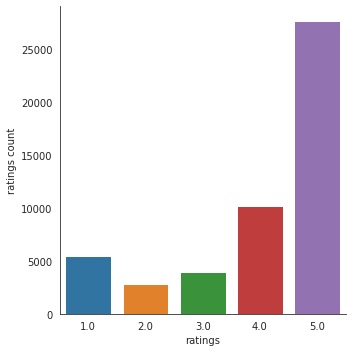

In [ ]:
with sns.axes_style('white'):
    g = sns.factorplot("ratings", data=electronics_dfnv, kind='count')
    g.set_ylabels("ratings count")


In [ ]:
print('unique users = ', electronics_dfnv['userId'].nunique())
print('unique products = ', electronics_dfnv['productId'].nunique())

unique users =  46554
unique products =  3446


**TAKING A SMALL SUBSET OF THE DATASET TO MAKE IT LESS DENSER**

In [ ]:
most_rated=electronics_dfnv.groupby('userId').size().sort_values()[46535:46554]
print('Counts of ratings: \n',most_rated)

Counts of ratings: 
 userId
A3A15L96IYUO6V    11
A6FIAB28IS79      11
A2BGZ52M908MJY    11
A1WVMDRJU19AFD    12
A2B7BUH8834Y6M    12
ARXU3FESTWMJJ     13
A6ZPLVAUQ6695     13
A3IBOQ8R44YG9L    14
A3MEIR72XKQY88    15
A7Y6AVS576M03     15
A23ZO1BVFFLGHO    15
A1MJMYLRTZ76ZX    16
A1ISUNUWG0K02V    16
A1RPTVW5VEOSI     17
A243HY69GIAHFI    18
A1NVD0TKNS1GT5    19
ALUNVOQRXOZIA     20
AY8Q1X7G96HV5     31
A231WM2Z2JL0U3    37
dtype: int64


In [ ]:
counts=electronics_dfnv.userId.value_counts()
electronics_dfnv_final=electronics_dfnv[electronics_dfnv.userId.isin(counts[counts>=15].index)]
print('Users who rated 25 or more items =', len(electronics_dfnv_final))
print('Number of unique users in the final data = ', electronics_dfnv_final['userId'].nunique())
print('Number of unique products in the final data = ', electronics_dfnv_final['productId'].nunique())

Users who rated 25 or more items = 219
Number of unique users in the final data =  11
Number of unique products in the final data =  186


In [ ]:
final_ratings_matrix = electronics_dfnv_final.pivot(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
final_ratings_matrix.head()

productId,1400599997,B00000DM9M,B00000J061,B00000J08C,B00000J0A2,B00000J0E8,B00000J1QZ,B00000J1US,B00000J3H5,B00000J3HB,...,B00004TDWY,B00004TE75,B00004TEN2,B00004TH2W,B00004TH2Y,B00004THCX,B00004THCY,B00004THCZ,B00004THDE,B00004THM6
userId,,,,,,,,,,,,,,,,,,,,,
A1ISUNUWG0K02V,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1MJMYLRTZ76ZX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1NVD0TKNS1GT5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1RPTVW5VEOSI,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
A231WM2Z2JL0U3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,5.0,5.0,0.0,4.0,0.0,0.0,0.0,5.0,0.0


In [ ]:
final_ratings_matrix.shape

(11, 186)

**SPLITTING THE DATASET**

In [ ]:
train_set, test_set = train_test_split(electronics_dfnv_final, test_size = 0.2, random_state=0)
train_set.head()

,userId,productId,ratings
43121,A231WM2Z2JL0U3,B00004SYB7,5.0
41412,A231WM2Z2JL0U3,B00004SD15,5.0
42189,A243HY69GIAHFI,B00004SPUT,4.0
47805,A1MJMYLRTZ76ZX,B00004TDN5,4.0
12356,A1MJMYLRTZ76ZX,B00000J434,4.0


In [ ]:
train_set.shape

(175, 3)

In [ ]:
test_set.shape

(44, 3)

In [ ]:
train_set_agg=train_set.groupby('productId').agg({'userId': 'count'}).reset_index()

In [ ]:
train_set_agg.rename(columns={'userId': 'score'},inplace=True)

In [ ]:
train_set_agg.head(10)

,productId,score
0,1400599997,1
1,B00000DM9M,1
2,B00000J061,1
3,B00000J08C,1
4,B00000J0A2,1
5,B00000J1QZ,1
6,B00000J3HB,1
7,B00000J3II,2
8,B00000J3Q7,1
9,B00000J3T1,1


In [ ]:
train_set_sorted = train_set_agg.sort_values(['score', 'productId'], ascending = [0,1])

In [ ]:
train_set_sorted['rank'] = train_set_sorted['score'].rank(ascending=0, method='first')

**BUILDING POPULARITY RECOMMENDER MODEL**

In [ ]:
pop_model = train_set_sorted.head()
pop_model.head()

,productId,score,rank
94,B00004RC2D,4,1.0
63,B00002SWHH,3,2.0
110,B00004SC3Y,3,3.0
111,B00004SCKA,3,4.0
7,B00000J3II,2,5.0


In [ ]:
def recommend(user_id):
    user_choices = pop_model
    user_choices['userId'] = user_id
    cols = user_choices.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    user_choices = user_choices[cols]
    return user_choices

In [ ]:
find_recom = [10,120]
for i in find_recom:
    print("Electronics recommended for user with userId: %d\n" %(i))
    print(recommend(i))

Electronics recommended for user with userId: 10

     userId   productId  score  rank
94       10  B00004RC2D      4   1.0
63       10  B00002SWHH      3   2.0
110      10  B00004SC3Y      3   3.0
111      10  B00004SCKA      3   4.0
7        10  B00000J3II      2   5.0
Electronics recommended for user with userId: 120

     userId   productId  score  rank
94      120  B00004RC2D      4   1.0
63      120  B00002SWHH      3   2.0
110     120  B00004SC3Y      3   3.0
111     120  B00004SCKA      3   4.0
7       120  B00000J3II      2   5.0


**BUILDING COLLABORATIVE FILTERING RECOMMENDER MODEL**

In [ ]:
electronics_dfcf = pd.concat([train_set, test_set]).reset_index()
electronics_dfcf.head()

,index,userId,productId,ratings
0,43121,A231WM2Z2JL0U3,B00004SYB7,5.0
1,41412,A231WM2Z2JL0U3,B00004SD15,5.0
2,42189,A243HY69GIAHFI,B00004SPUT,4.0
3,47805,A1MJMYLRTZ76ZX,B00004TDN5,4.0
4,12356,A1MJMYLRTZ76ZX,B00000J434,4.0


**BUILDING USER BASED COLLABORATIVE FILTERING MODEL**

In [ ]:
electronics_dfucf = electronics_dfcf.pivot(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
electronics_dfucf.head()

productId,1400599997,B00000DM9M,B00000J061,B00000J08C,B00000J0A2,B00000J0E8,B00000J1QZ,B00000J1US,B00000J3H5,B00000J3HB,...,B00004TDWY,B00004TE75,B00004TEN2,B00004TH2W,B00004TH2Y,B00004THCX,B00004THCY,B00004THCZ,B00004THDE,B00004THM6
userId,,,,,,,,,,,,,,,,,,,,,
A1ISUNUWG0K02V,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1MJMYLRTZ76ZX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1NVD0TKNS1GT5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1RPTVW5VEOSI,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
A231WM2Z2JL0U3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,5.0,5.0,0.0,4.0,0.0,0.0,0.0,5.0,0.0


In [ ]:
electronics_dfucf.shape

(11, 186)

In [ ]:
electronics_dfucf['user_ind'] = np.arange(0, electronics_dfucf.shape[0], 1)
electronics_dfucf.set_index(['user_ind'], inplace=True)
electronics_dfucf.head()

productId,1400599997,B00000DM9M,B00000J061,B00000J08C,B00000J0A2,B00000J0E8,B00000J1QZ,B00000J1US,B00000J3H5,B00000J3HB,...,B00004TDWY,B00004TE75,B00004TEN2,B00004TH2W,B00004TH2Y,B00004THCX,B00004THCY,B00004THCZ,B00004THDE,B00004THM6
user_ind,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,5.0,5.0,0.0,4.0,0.0,0.0,0.0,5.0,0.0


**PERFORMING SVD**

In [ ]:
U, sigma, Vt = svds(electronics_dfucf, k = 5)

In [ ]:
print('Left singular matrix: \n',U)
sigma = np.diag(sigma)
print('Diagonal matrix: \n',sigma)
print('Right singular matrix: \n',Vt)

Left singular matrix: 
 [[ 4.93636653e-02 -1.66297884e-01 -3.12732051e-01  1.53122256e-01
   1.38465143e-01]
 [ 8.18019500e-01  2.13209931e-01  2.76257471e-01  2.09061119e-01
   1.01498819e-01]
 [-1.89642626e-01  6.60636300e-01 -2.07100247e-01 -3.59790632e-02
   1.23044532e-01]
 [-9.74799278e-02  5.43326589e-02 -2.99913518e-01  1.00398248e-01
   1.16155900e-01]
 [-1.33412578e-01 -9.24837886e-02  2.48586367e-01 -1.79064339e-01
   9.26201600e-01]
 [ 4.06414738e-01  1.22417282e-01 -4.14339191e-01 -4.04459226e-03
   2.33218097e-01]
 [-1.25896947e-01  5.86529180e-01 -1.64067216e-01 -9.37707797e-03
   1.79755959e-02]
 [-4.29965080e-02 -5.56583151e-04 -2.51788542e-02 -9.00894193e-04
   3.04631617e-02]
 [-1.54469490e-01 -6.89319218e-02  9.60100045e-02 -2.28758644e-02
   4.64399549e-02]
 [ 7.39304558e-02 -3.36795340e-01 -6.29018917e-01  1.54119324e-01
   1.21495612e-01]
 [-2.30094616e-01  4.18979575e-02  1.64726898e-01  9.30068553e-01
   1.07164263e-01]]
Diagonal matrix: 
 [[18.83061496  0.    

In [ ]:
ratings_predicted = np.dot(np.dot(U, sigma), Vt)
predicted_df = pd.DataFrame(ratings_predicted, columns = electronics_dfucf.columns)
predicted_df.head()

productId,1400599997,B00000DM9M,B00000J061,B00000J08C,B00000J0A2,B00000J0E8,B00000J1QZ,B00000J1US,B00000J3H5,B00000J3HB,...,B00004TDWY,B00004TE75,B00004TEN2,B00004TH2W,B00004TH2Y,B00004THCX,B00004THCY,B00004THCZ,B00004THDE,B00004THM6
0,0.296794,0.437057,0.557010,0.437057,1.187177,-0.116299,0.511536,0.159406,0.852561,0.852561,...,1.483971,0.159406,0.159406,0.557010,0.127524,0.349646,0.262234,0.349646,0.159406,0.349646
1,-0.140551,0.357682,-0.591153,0.357682,-0.562203,-0.573007,-0.106214,-0.018029,-0.177023,-0.177023,...,-0.702754,-0.018029,-0.018029,-0.591153,-0.014423,0.286146,0.214609,0.286146,-0.018029,0.286146
2,-0.096845,0.084615,0.635864,0.084615,-0.387381,-0.147957,-0.128786,0.165634,-0.214644,-0.214644,...,-0.484227,0.165634,0.165634,0.635864,0.132507,0.067692,0.050769,0.067692,0.165634,0.067692
3,0.192731,0.405636,0.629872,0.405636,0.770925,-0.071924,0.334206,0.115159,0.557010,0.557010,...,0.963656,0.115159,0.115159,0.629872,0.092127,0.324509,0.243382,0.324509,0.115159,0.324509
4,-0.050149,0.002425,0.115159,0.002425,-0.200594,0.489795,0.095643,4.890304,0.159406,0.159406,...,-0.250743,4.890304,4.890304,0.115159,3.912243,0.001940,0.001455,0.001940,4.890304,0.001940


In [ ]:
def recommend_items(userID, electronics_dfucf, predicted_df,rec_num):
    user_idx = userID-1
    sorted_ratings = electronics_dfucf.iloc[user_idx].sort_values(ascending=False)
    sorted_predictions = predicted_df.iloc[user_idx].sort_values(ascending=False)
    temp = pd.concat([sorted_ratings, sorted_predictions], axis=1)
    temp.index.name = 'Items Recommended'
    temp.columns = ['user_ratings', 'user_predictions']
    temp = temp.loc[temp.user_ratings == 0]
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nItems curated for the user(user_id = {}):\n'.format(userID))
    print(temp.head(rec_num))

In [ ]:
userID = 10
rec_num = 5
recommend_items(userID, electronics_dfucf, predicted_df, rec_num)


Items curated for the user(user_id = 10):

                   user_ratings  user_predictions
Items Recommended                                
B00004SCKA                  0.0          2.669155
B000038ABH                  0.0          2.592594
B00000JX2V                  0.0          1.483971
B00000J3H5                  0.0          1.483971
B00000J3HB                  0.0          1.483971


**EVALUATING COLLABORATIVE RECOMMENDER MODEL**

In [ ]:
final_ratings_matrix.head()
final_ratings_matrix.mean().head()
predicted_df.head()
predicted_df.mean().head()

productId,1400599997,B00000DM9M,B00000J061,B00000J08C,B00000J0A2,B00000J0E8,B00000J1QZ,B00000J1US,B00000J3H5,B00000J3HB,...,B00004TDWY,B00004TE75,B00004TEN2,B00004TH2W,B00004TH2Y,B00004THCX,B00004THCY,B00004THCZ,B00004THDE,B00004THM6
userId,,,,,,,,,,,,,,,,,,,,,
A1ISUNUWG0K02V,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1MJMYLRTZ76ZX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1NVD0TKNS1GT5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1RPTVW5VEOSI,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
A231WM2Z2JL0U3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,5.0,5.0,0.0,4.0,0.0,0.0,0.0,5.0,0.0


productId
1400599997    0.090909
B00000DM9M    0.454545
B00000J061    0.454545
B00000J08C    0.454545
B00000J0A2    0.363636
dtype: float64

productId,1400599997,B00000DM9M,B00000J061,B00000J08C,B00000J0A2,B00000J0E8,B00000J1QZ,B00000J1US,B00000J3H5,B00000J3HB,...,B00004TDWY,B00004TE75,B00004TEN2,B00004TH2W,B00004TH2Y,B00004THCX,B00004THCY,B00004THCZ,B00004THDE,B00004THM6
0,0.296794,0.437057,0.557010,0.437057,1.187177,-0.116299,0.511536,0.159406,0.852561,0.852561,...,1.483971,0.159406,0.159406,0.557010,0.127524,0.349646,0.262234,0.349646,0.159406,0.349646
1,-0.140551,0.357682,-0.591153,0.357682,-0.562203,-0.573007,-0.106214,-0.018029,-0.177023,-0.177023,...,-0.702754,-0.018029,-0.018029,-0.591153,-0.014423,0.286146,0.214609,0.286146,-0.018029,0.286146
2,-0.096845,0.084615,0.635864,0.084615,-0.387381,-0.147957,-0.128786,0.165634,-0.214644,-0.214644,...,-0.484227,0.165634,0.165634,0.635864,0.132507,0.067692,0.050769,0.067692,0.165634,0.067692
3,0.192731,0.405636,0.629872,0.405636,0.770925,-0.071924,0.334206,0.115159,0.557010,0.557010,...,0.963656,0.115159,0.115159,0.629872,0.092127,0.324509,0.243382,0.324509,0.115159,0.324509
4,-0.050149,0.002425,0.115159,0.002425,-0.200594,0.489795,0.095643,4.890304,0.159406,0.159406,...,-0.250743,4.890304,4.890304,0.115159,3.912243,0.001940,0.001455,0.001940,4.890304,0.001940


productId
1400599997    0.083714
B00000DM9M    0.528221
B00000J061    0.343846
B00000J08C    0.528221
B00000J0A2    0.334857
dtype: float64

**FINAL RESULTS**

In [ ]:
userID = 8
rec_num = 5
recommend_items(userID, electronics_dfucf, predicted_df, rec_num)


Items curated for the user(user_id = 8):

                   user_ratings  user_predictions
Items Recommended                                
B00004RC2D                  0.0          0.349910
B00004SB92                  0.0          0.315636
B00004S9AK                  0.0          0.206651
B00004R8VC                  0.0          0.179223
B00001YVG4                  0.0          0.168014


In [ ]:
userID = 10
rec_num = 5
recommend_items(userID, electronics_dfucf, predicted_df, rec_num)


Items curated for the user(user_id = 10):

                   user_ratings  user_predictions
Items Recommended                                
B00004SCKA                  0.0          2.669155
B000038ABH                  0.0          2.592594
B00000JX2V                  0.0          1.483971
B00000J3H5                  0.0          1.483971
B00000J3HB                  0.0          1.483971
